# AFPS Data Export
<br>
This notebook serves as the unifier for the three classes: Synthesis, AggregationFinder and Plotter. You can read moe about what each class does within the class itself, the supporting information or the paper. 
<br>

DOI: 


In [1]:
from utils.afps_dataiter import Synthesis
from utils.aggregationfinder import AggregationFinder
from utils.permutator import DeletionPermutator
from utils.plotting import SynthesisPlotter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

serial needs to be a dictionary where the keys are the serial numbers of the syntheses you wish to analyze and the values is the name which you want to assign to that particular synthesis. An instance of type synthesis is then instantiated from the serial number by the class method from_serial



Serial number:  1016
Synthesis name: standard_barstar
['RESIN AMOUNT [mg]:150.00']
['NOTEBOOK NUMBER: PLW-01-028']
['NUMBER OF STEPS: 374']
'parse_afps_datafile'  1330.56 ms


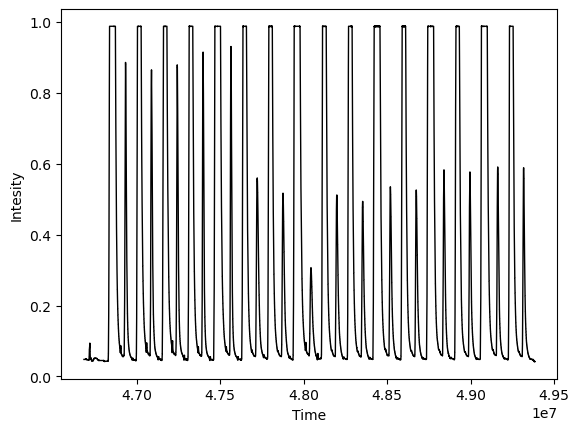

16 deprotection peaks found
16 residues in sequence
37399


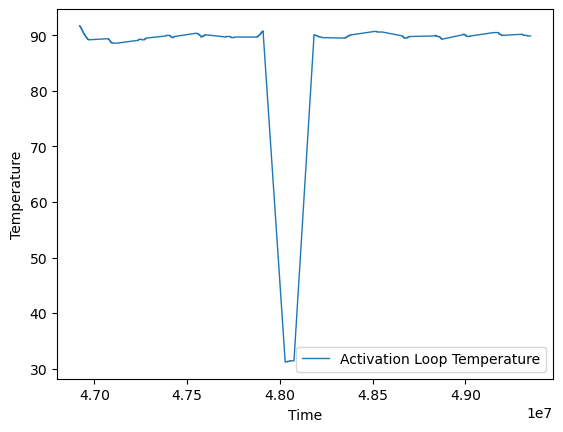

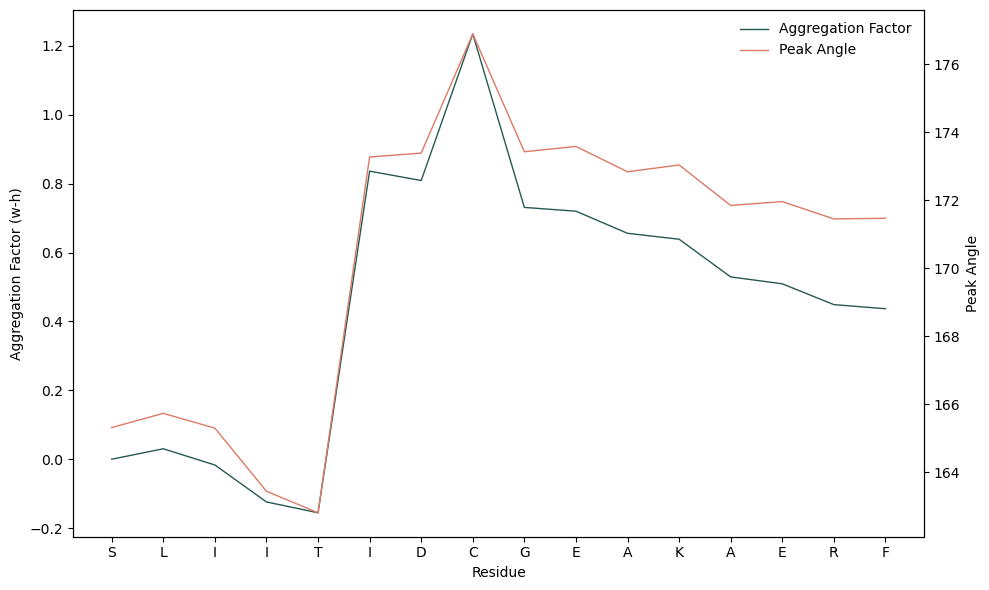



Temperature profile


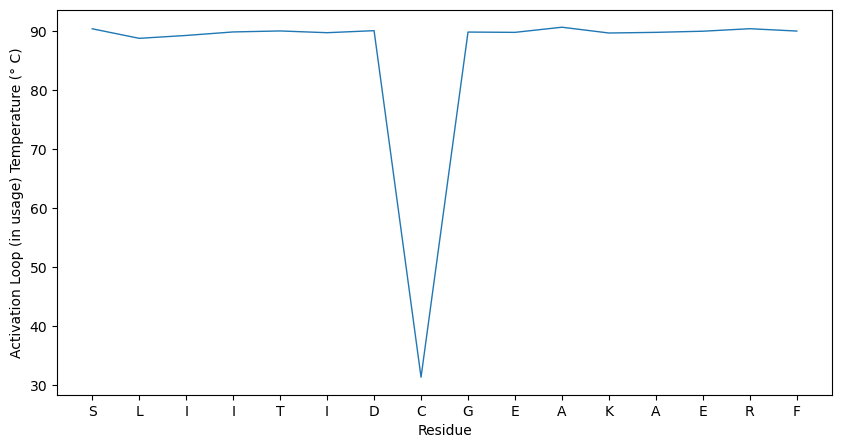

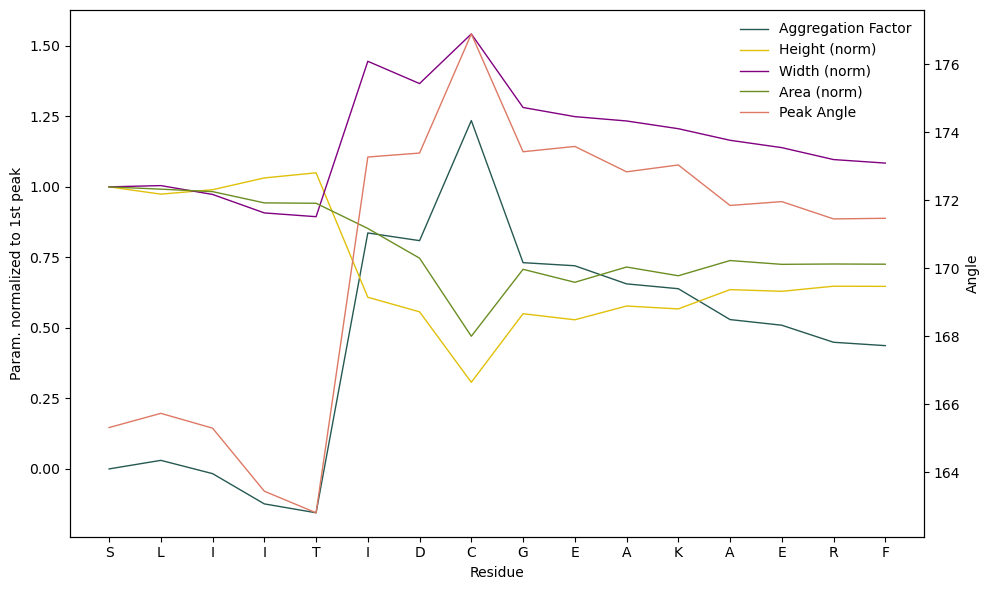



Temperature profile


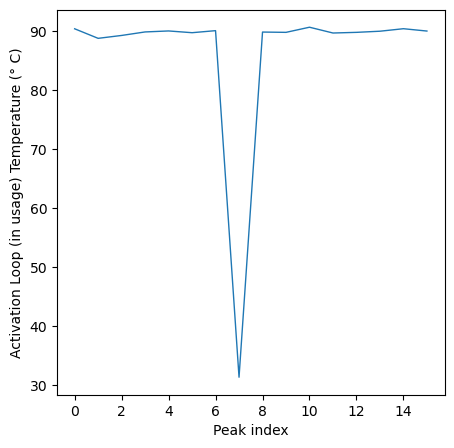

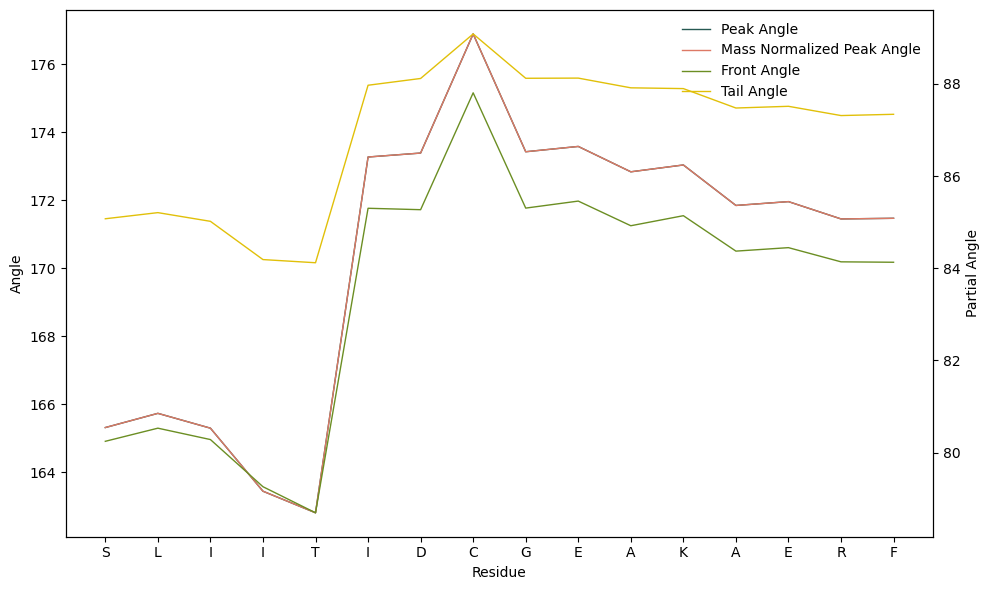

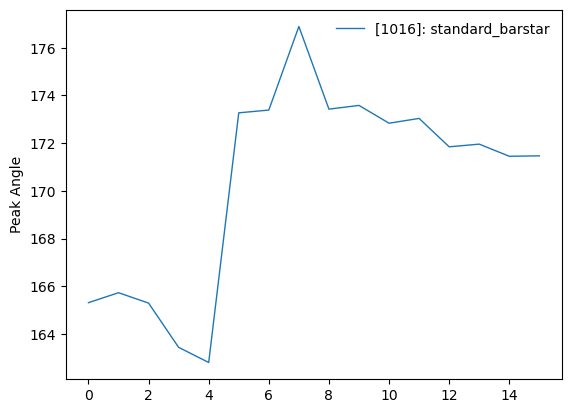

In [2]:
combo = pd.DataFrame()
serial = {1016:"standard_barstar"} #{serial number (int) : name (str)}
for sn, name in serial.items():
    print(f"\n\nSerial number:  {sn}\nSynthesis name: {name}")
    syn = Synthesis.from_serial(sn) #instantiate a synthesis object from the serial number
    syn.plot_uv()
    integrals = syn.get_integrals()
    syn.plot_depro_temp()
    plot = SynthesisPlotter(integrals)
    plot.plot_integrals(save=None) #to save as name.pdf set save=name+".pdf" 
    plot.plot_4_integrals(save=None) #uncomment to plot height,area and width aswell as angle and aggregation factor
    plot.plot_angle(save=None)
    local = pd.DataFrame(integrals, columns=['AA number', 'AA Name', 'Area', 'Height', 'Width', "Peak Angle", "Front Angle", "Tail Angle", "Asymmetry Factor", "t_loop", "t_reac", "resinmass", "angle_mass_norm"])
    local["first_area"] = local["Area"] / local.loc[0,"Area"]
    local["first_height"] = local["Height"] / local.loc[0,"Height"]
    local["first_width"] = local["Width"] / local.loc[0,"Width"]
    local["first_diff"] = local["first_width"] - local["first_height"]
    local["serial_n"] = sn
    local = syn.add_params(local)
    combo = combo.append(local, ignore_index=True)
    
    
plot.plot_compare(combo, "Peak Angle", serial)    


In [3]:
perm = DeletionPermutator(combo, 1016)
perm_df = perm.permute_sequence()
perm_df = perm.compute_mass()
perm_df.head(10)

Calculating permutation probabilities...


100%|██████████| 32767/32767 [00:06<00:00, 5212.12it/s]


Calculating masses...


100%|██████████| 17278/17278 [00:15<00:00, 1099.24it/s]


,Sequence,Probability,Probability Normalised,Rank,Mass
0,SLIITIDGEAKAERF,0.018944394115204707,1.0,1,1660.898836
1,SLIITIDGAKAERF,0.009688215677370594,0.5114027726859243,2,1531.856243
2,SLIITIDGEAAERF,0.00871953566972714,0.46026996781749124,3,1532.803873
3,SLIITIDCGAKAERF,0.008603700289552332,0.4541554740273816,4,1634.865428
4,SLIITIDEAKAERF,0.007825241795893053,0.4130637141682214,5,1603.877372
5,SLIITIDCGEAAERF,0.007743455974212372,0.40874656255158354,6,1635.813058
6,SLIITIDGEKAERF,0.007521815058376347,0.39704701098565953,7,1589.861722
7,SLIITIDGEAKARF,0.007176172363418621,0.3788018935722547,8,1531.856243
8,SLIITIDGEAKAER,0.007157966049060388,0.37784085389753524,9,1513.830422
9,SLIITIDGEAKAEF,0.007131566085326039,0.37644730372254387,10,1504.797725


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Cumulative Slope Aggregation Prediction:
Index of aggregation = 4.0
Magnitude of aggregation = 1.72

Sigmoid Aggregation Prediction:
x-value of inflection point = -0.86	   (out of range)
Amplitude of sigmoid = 199.90	  (magnitude of aggregation)
Gradient at inflection point = -99.70
R2 = -0.0000


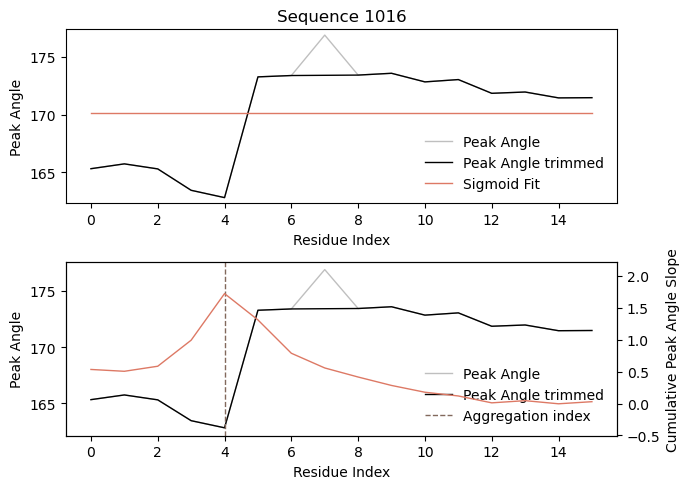

In [4]:

aggr_finder = AggregationFinder(combo, "Peak Angle")

combo, aggregation_df = aggr_finder.find_aggregation()
# uncomment (remove ")#") the next line to save pdf of plot.
aggr_finder.plot_aggregation_for_paper(sn=1016, save="std_barstar_cumulative_gradient_and_sigmoid.pdf") #, save=wb.replace(".xlsx","_aggreg.pdf"))
